In [3]:
import cv2
import matplotlib.pyplot as plt
import sklearn
import numpy as np

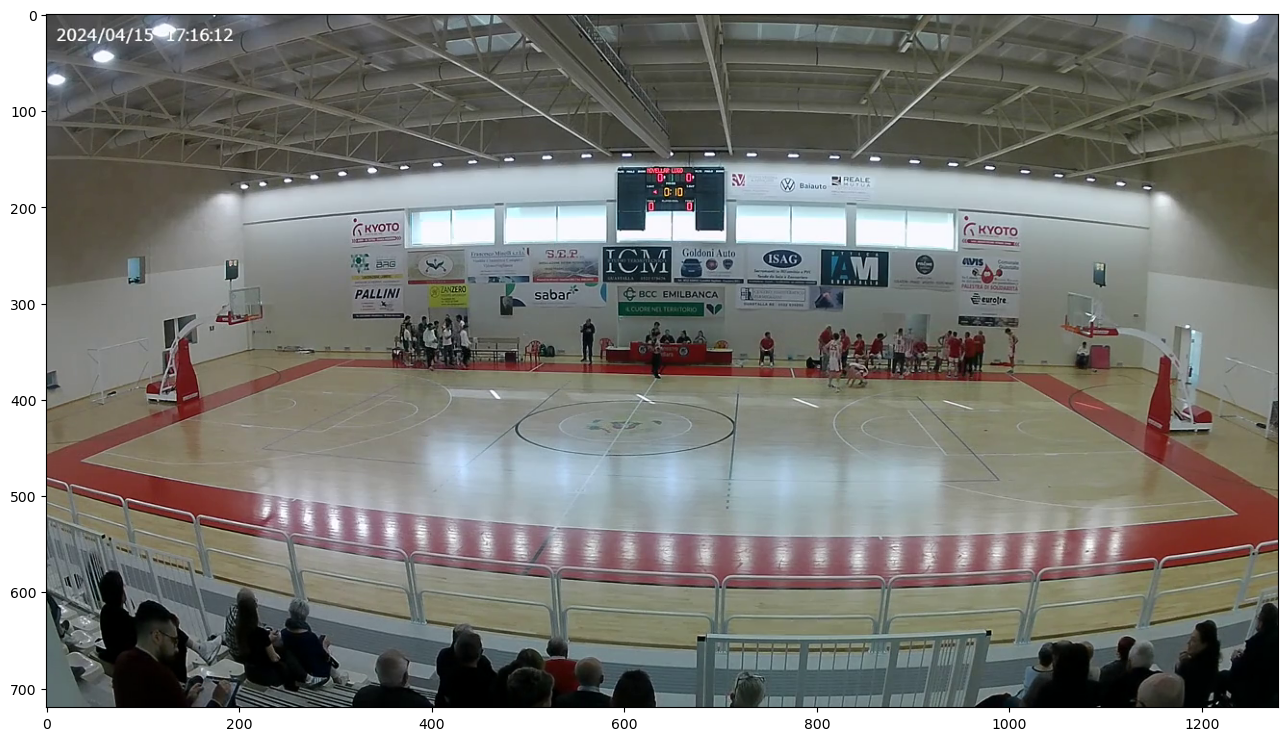

In [36]:
cap = cv2.VideoCapture('/work/cvcs2024/Basketball_Video_Analysis/input_videos/1.mp4')

for _ in range(10000):
    ret, img = cap.read()

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(16,9))
plt.imshow(img)

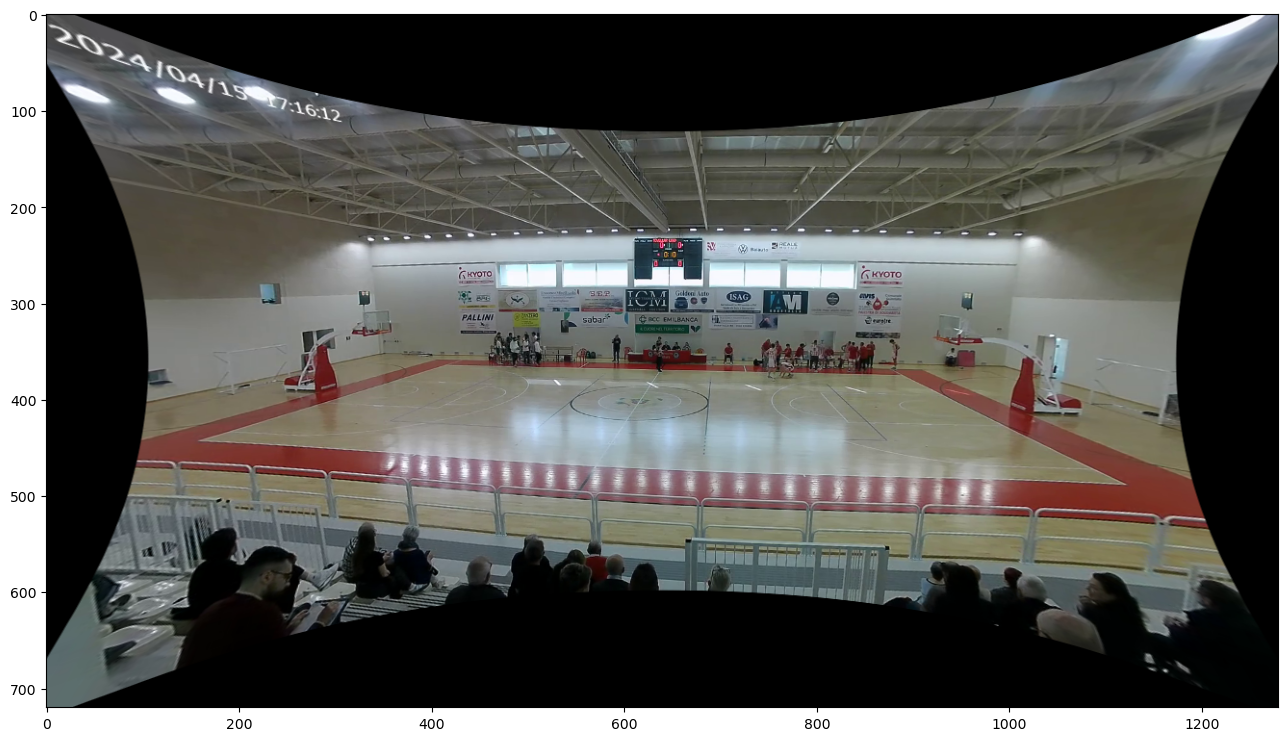

In [148]:
h, w = img.shape[:2]

fx, fy = 1150, 1150
cx, cy = w/2, h/2
k1 = -0.55
k2 = 0.17
k3 = 0
k4 = 0
"""
k1: -0.3 a -0.6
k2: 0.1 a 0.3
k3: -0.0001 a -0.001
k4: 0.00001 a 0.0001
"""

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0,  0,  1]]) 
D = np.array([k1, k2, k3, k4])  


new_K, roi = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 1, (w, h))

undistorted_img = cv2.undistort(img, K, D, None, new_K)

plt.figure(figsize=(16,9))
plt.imshow(undistorted_img)


Ritaglio l'immagine

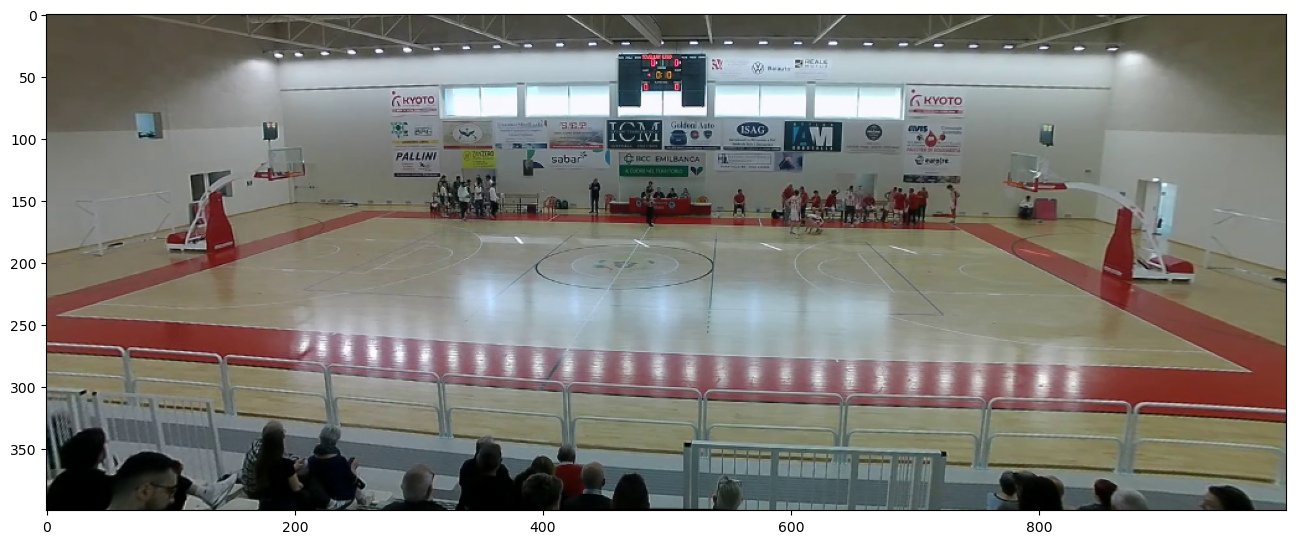

In [161]:
undistorted_img2 = undistorted_img[200:600, 150:1150].copy()

plt.figure(figsize=(16,9))
plt.imshow(undistorted_img2)

In [184]:
in_corners = np.array([(265,164), (3,243), (738, 173), (974, 289)])

out_corners = np.array([(0,0), (0, h), (w, 0), (w, h)])

H, status = cv2.findHomography(in_corners, out_corners)

img_trasformata = cv2.warpPerspective(undistorted_img2, H, (w, h))

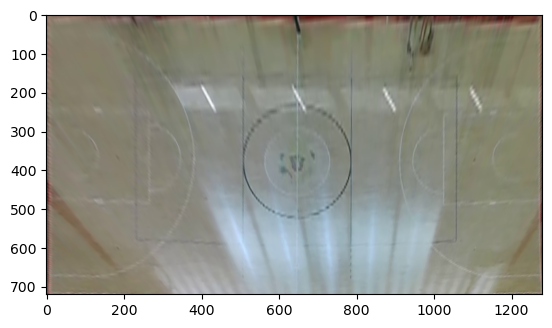

In [185]:
plt.imshow(img_trasformata)

In [167]:
gray = cv2.cvtColor(img_trasformata, cv2.COLOR_BGR2GRAY)


circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0]/8,
param1=200, param2=30,
maxRadius=180)

In [168]:
src = img_trasformata.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(src, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(src, center, radius, (255, 0, 255), 3)

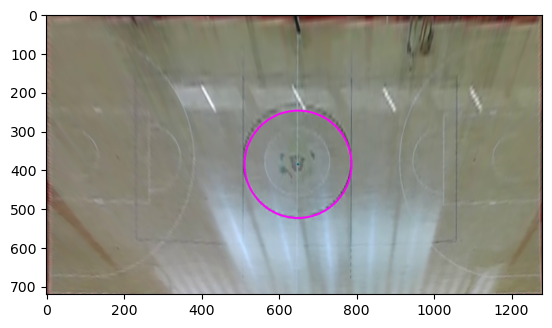

In [169]:
plt.imshow(src)

In [180]:
from sklearn.cluster import KMeans

def most_frequent_color(image, k=5):
    # Ridimensiona l'immagine per accelerare il clustering (opzionale)
    image_rgb_small = cv2.resize(image, (0, 0), fx=0.25, fy=0.25)
    
    # Reshape l'immagine in un array 2D di pixel
    pixels = image_rgb_small.reshape(-1, 3)
    
    # Applica il k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pixels)
    
    # Trova i centri dei cluster
    centers = kmeans.cluster_centers_
    
    labels = kmeans.labels_

    return np.array(centers[np.bincount(labels).argsort()], dtype='int32')

def filter_color(img, colors, verbose=False):

    multiply_factor_up = np.array([1.3, 1.2, 1.2])
    multiply_factor_down = np.array([2, 2, 2]) - multiply_factor_up

    mask = np.zeros((img.shape[0], img.shape[1], 1))

    for color in colors:
        mask1 = np.expand_dims((img >= color*multiply_factor_down).all(axis=-1), 2)
        mask2 = np.expand_dims((img <= color*multiply_factor_up).all(axis=-1), 2)

        mask = mask + mask1 * mask2
        
    tmp = np.where(mask, img, np.zeros(3, dtype='uint8'))
    if verbose:
        plt.imshow(tmp, cmap='gray')
        
    return tmp

In [181]:
c = most_frequent_color(img_trasformata)

c

array([[100,  69,  60],
       [167, 185, 195],
       [149, 156, 155],
       [128, 124, 104],
       [135, 136, 124]], dtype=int32)

array([[[140, 107,  95],
        [143, 112,  99],
        [145, 117, 104],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[137, 105,  93],
        [142, 110,  98],
        [144, 115, 102],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[136, 103,  91],
        [141, 109,  96],
        [143, 113, 100],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [153, 109,  99]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [157, 116, 108],
        [145, 101,  94],
        [  0,   0,   0]]

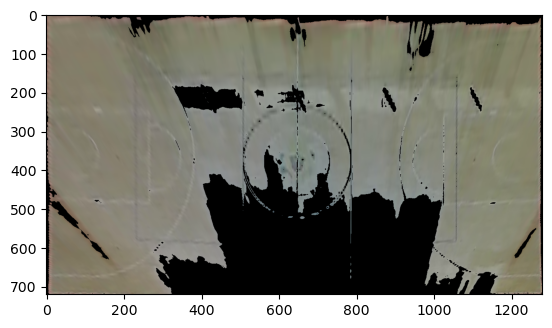

In [183]:
filter_color(img_trasformata, c[-2:], True)

In [162]:
cv2.imwrite('novellara_undistorted2.jpg', cv2.cvtColor(undistorted_img2, cv2.COLOR_RGB2BGR))

True